Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
controlDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
lpsDirectory = '/home/h1bennet/strains/data/ATAC/LPS_2hours/'
workingDirectory = '/home/h1bennet/strains/results/09_Strains_LPS_2h_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Read in raw gene expression files

In [4]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

In [5]:
best_reps = [ '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB1_TDT_l20210213_TCATGAGC_CTCTCTAT_S15_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB2_TDT_l20210213_CCTGAGAT_TATCCTCT_S16_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB3_TDT_l20210213_TAGCGAGT_GTAAGGAG_S17_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB4_TDT_l20210213_GTAGCTCC_ACTGCATA_S18_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331C_TDT_s20210331_TCCTGAGC_CCTAGAGT.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331D_TDT_s20210331_GGACTCCT_GCGTAAGA.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407E_TDT_s20210407_GCTCATGA_CTCTCTAT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407F_TDT_s20210407_ATCTCAGG_TATCCTCT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam']

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_idr_peaks_merged.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt', sep='\t')

In [7]:
groups = [[0,1,2,3],
         [4,5],
         [6,7,8,9],
         [10,11]]
thresh = 16

subset comparisons that we want to do

In [8]:
strains = ['c57bl6j', 'balbcj', 'LPS2hrFasted', 'healthyoung']
df, mat = read_annotated_peaks(
    './merged_peaks/ann_raw_idr_peaks_merged.txt')
df.index.rename('PeakID')
# drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > thresh, :].index.tolist())
df = df.reindex(list(set(peaks)))
df = df.dropna(how='all')
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

for strain in strains:
    print(strain)
    # pull out selected strain
    tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains(strain))
    # print(tst)
    tmp = df.loc[:, tst]
    print(tmp.columns)
    tmp.to_csv(
        './merged_peaks/'+strain+'_ann_raw_amln_control_idr_atac_peaks_merged.txt',
        sep='\t')

93426 total peaks
filtering low tag count peaks
90128 total peaks
c57bl6j
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C571_TDT_l20210213_TACTACGC_AAGGAGTA_S19_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C572_TDT_l20210213_AGGCTCCG_CTAAGCCT_S20_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C573_TDT_l20210213_GCAGCGTA_CGTCTAAT_S21_L001_trim30',
       '/home/h1bennet/strains/data/ATAC/control_cohort2/c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C574_TDT_l20210213_CTGCGCAT_TCTCTCCG_S22_L001

### Run Differential Peaks for All Samples

In [84]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/c57bl6j_ann_raw_amln_control_idr_atac_peaks_merged.txt \
# 00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control \
# 01_c57bl6j_lps2h 01_c57bl6j_lps2h \
# -peaks > ./merged_peaks/c57bl6j_diff_output.txt


	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_c57bl6j_control vs. 01_c57bl6j_lps2h:
		Total Genes: 90128
		Total Up-regulated in 01_c57bl6j_lps2h vs. 00_c57bl6j_control: 11781 (13.071%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_c57bl6j_lps2h vs. 00_c57bl6j_control: 7271 (8.067%) [log2fold<-1, FDR<0.05]



In [85]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/balbcj_ann_raw_amln_control_idr_atac_peaks_merged.txt \
# 00_balbcj_control 00_balbcj_control 00_balbcj_control 00_balbcj_control \
# 01_balbcj_lps2h 01_balbcj_lps2h \
# -peaks > ./merged_peaks/balbcj_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbcj_control vs. 01_balbcj_lps2h:
		Total Genes: 90128
		Total Up-regulated in 01_balbcj_lps2h vs. 00_balbcj_control: 13281 (14.736%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_balbcj_lps2h vs. 00_balbcj_control: 8347 (9.261%) [log2fold<-1, FDR<0.05]



## Control

In [88]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/healthyoung_ann_raw_amln_control_idr_atac_peaks_merged.txt \
# 00_balbcj_control 00_balbcj_control 00_balbcj_control 00_balbcj_control \
# 00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control 00_c57bl6j_control \
# -peaks > ./merged_peaks/control_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbcj_control vs. 00_c57bl6j_control:
		Total Genes: 90128
		Total Up-regulated in 00_c57bl6j_control vs. 00_balbcj_control: 2883 (3.199%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 00_c57bl6j_control vs. 00_balbcj_control: 4137 (4.590%) [log2fold<-1, FDR<0.05]



## LPS Treatment

In [87]:
# %%bash

# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/LPS2hrFasted_ann_raw_amln_control_idr_atac_peaks_merged.txt \
# 00_balbcj_lps2h 00_balbcj_lps2h \
# 01_c57bl6j_lps2h 01_c57bl6j_lps2h \
# -peaks > ./merged_peaks/lps2h_diff_output.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_balbcj_lps2h vs. 01_c57bl6j_lps2h:
		Total Genes: 90128
		Total Up-regulated in 01_c57bl6j_lps2h vs. 00_balbcj_lps2h: 1512 (1.678%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_c57bl6j_lps2h vs. 00_balbcj_lps2h: 2296 (2.547%) [log2fold<-1, FDR<0.05]



# Scatter plot of differentially acetylated enhancers

In [9]:
log2fc = np.log2(2)
pval = 0.05

## C57BL6J

In [10]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/c57bl6j_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 27)
annotatePeaks selected peaks (90128, 30)


dict_keys(['00_c57bl6j_control vs. 01_c57bl6j_lps2h'])

In [163]:
comps = ['00_c57bl6j_control vs. 01_c57bl6j_lps2h']

groups = [[[4,5,6,7],[10,11]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#31a354', '#006d2c']]

00_c57bl6j_control vs. 01_c57bl6j_lps2h
N peaks downregulated 7185
N peaks upregulated 11781



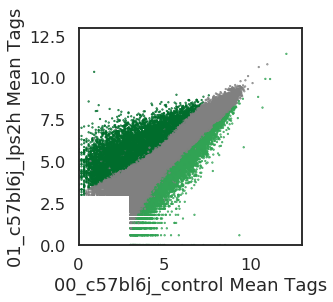

In [164]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## BALBCJ

In [157]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/balbcj_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 27)
annotatePeaks selected peaks (90128, 30)


dict_keys(['00_balbcj_control vs. 01_balbcj_lps2h'])

In [158]:
comps = ['00_balbcj_control vs. 01_balbcj_lps2h']

groups = [[[1,2,3,4],[8,9]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#08519c']]

00_balbcj_control vs. 01_balbcj_lps2h
N peaks downregulated 8347
N peaks upregulated 13281



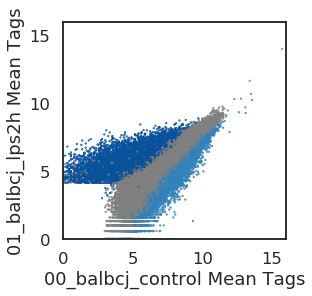

In [159]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Strains Control Comparison

In [142]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/control_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 29)
annotatePeaks selected peaks (90128, 30)


dict_keys(['00_balbcj_control vs. 00_c57bl6j_control'])

In [144]:
comps = ['00_balbcj_control vs. 00_c57bl6j_control']

groups = [[[0,1,2,3],[4,5,6,7]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

00_balbcj_control vs. 00_c57bl6j_control
N peaks downregulated 4137
N peaks upregulated 2864



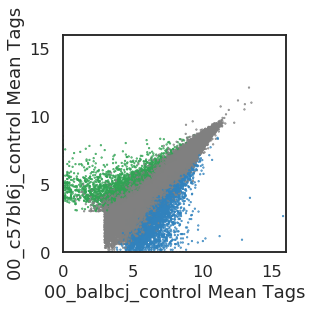

In [155]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Strains LPS Comparison

In [165]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/lps2h_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 25)
annotatePeaks selected peaks (90128, 30)


dict_keys(['00_balbcj_lps2h vs. 01_c57bl6j_lps2h'])

In [166]:
comps = ['00_balbcj_lps2h vs. 01_c57bl6j_lps2h']

groups = [[[8,9],[10,11]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#08519c', '#006d2c']]

00_balbcj_lps2h vs. 01_c57bl6j_lps2h
N peaks downregulated 2296
N peaks upregulated 1512



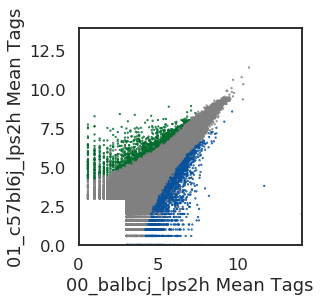

In [167]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Lets look at a log-log plot of the effect of strain in LPS and in Control settings

In [12]:
diff_peak_control, peaks_control, peak_mat_control, peak_mat_quant_control = import_homer_diffpeak(
    './merged_peaks/control_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

diff_peak_lps, peaks_lps, peak_mat_lps, peak_mat_quant_lps = import_homer_diffpeak(
    './merged_peaks/lps2h_diff_output.txt',
    './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 29)
annotatePeaks selected peaks (90128, 30)
annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 25)
annotatePeaks selected peaks (90128, 30)


In [15]:
groups = ['balbcj_Male_Kupffer_ATAC_Chow',
          'c57bl6j_Male_Kupffer_ATAC_Chow',
          'balbcj_Male_Kupffer_ATAC_LPS2hrFasted',
          'c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted']

In [16]:
avg_norm_tag_dict = {}
for group in groups:
    avg = peak_mat.loc[:, peak_mat.columns.str.contains(group)].mean(1)
    avg_norm_tag_dict[group] = avg
    
avg_norm_tag_df = pd.DataFrame(avg_norm_tag_dict)
# log transform data
log_norm_tag_df = np.log2(avg_norm_tag_df+1)

Calculate log fold change log(A/B) = log(A)-log(B)

In [30]:
log_norm_tag_df['strain_control'] = log_norm_tag_df['c57bl6j_Male_Kupffer_ATAC_Chow'] \
- log_norm_tag_df['balbcj_Male_Kupffer_ATAC_Chow']

log_norm_tag_df['strain_lps'] = log_norm_tag_df['c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted'] \
- log_norm_tag_df['balbcj_Male_Kupffer_ATAC_LPS2hrFasted']

log_norm_tag_df['lps_balb'] = log_norm_tag_df['balbcj_Male_Kupffer_ATAC_LPS2hrFasted'] \
- log_norm_tag_df['balbcj_Male_Kupffer_ATAC_Chow']

log_norm_tag_df['lps_c57'] = log_norm_tag_df['c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted'] \
- log_norm_tag_df['c57bl6j_Male_Kupffer_ATAC_Chow']

In [40]:
similar = (np.abs(log_norm_tag_df.strain_lps) < 1) & (np.abs(log_norm_tag_df.strain_control) < 1)
cis = (np.abs(log_norm_tag_df.strain_lps - log_norm_tag_df.strain_control) < 1) & (~similar)
lps_spec = (((~similar) & (~cis)) & (np.abs(log_norm_tag_df.strain_lps) > 1) & ((np.abs(log_norm_tag_df.strain_control) < 1)))
control_spec = ((~similar) & (~cis)) & (~lps_spec)

Text(0, 0.5, 'Log2(C57BL6J LPS /BALBCJ LPS)')

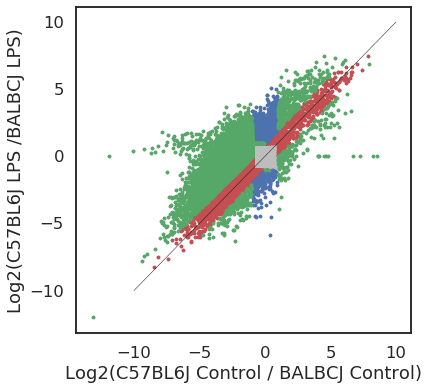

In [46]:
fig, ax = plt.subplots(figsize=(6,6))


ax.plot([-10,10],
        [-10,10],
        c='k',
        linewidth=0.5)

ax.scatter(log_norm_tag_df.strain_control,
           log_norm_tag_df.strain_lps,
           s=5,
           c='#bdbdbd')

ax.scatter(log_norm_tag_df.strain_control[cis],
           log_norm_tag_df.strain_lps[cis],
           s=5,
           c='r')

ax.scatter(log_norm_tag_df.strain_control[lps_spec],
           log_norm_tag_df.strain_lps[lps_spec],
           s=5,
           c='b')

ax.scatter(log_norm_tag_df.strain_control[control_spec],
           log_norm_tag_df.strain_lps[control_spec],
           s=5,
           c='g')

ax.set_xlabel('Log2(C57BL6J Control / BALBCJ Control)')
ax.set_ylabel('Log2(C57BL6J LPS /BALBCJ LPS)')

# ax.set_xlim([-5,5]);
# ax.set_ylim([-5,5]);

## Extract all peaks that have significant differences in ATAC tags

Iterate through the three DESeq2 outputs and select differential peaks, store in the peak dict for processing.
For the LPS comparison "up" is up in C57 compared to Balb

In [168]:
from matplotlib_venn import venn2

In [184]:
if not os.path.isdir('./peak_files/'):
    os.mkdir('./peak_files/')

In [192]:
convert_dict = {'Start': int,
                'End': int}

# set p value and log2fcs
padj = 0.05
log2fc = np.log2(2)

peak_dict = {}

for i in glob.glob('./merged_peaks/*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './merged_peaks/ann_raw_idr_peaks_merged_samples_filtered.txt')
    
    # extract comparison name
    comp_name = i.split('/')[-1].split('_')[0]
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # activated peaks stored in the [0] position.
    peak_dict[i.split('/')[-1].split('_')[0].replace('./','')] = [act, rep]
    
    # save to list
    print(comp_name)
    print('n activated peaks:',diff_peak.reindex(act).dropna(how='all').shape[0])
    diff_peak.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal activated peaks:',diff_peak_distal.reindex(act).dropna(how='all').shape[0])
    diff_peak_distal.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_distal_act_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n repressed peaks:',diff_peak.reindex(rep).dropna(how='all').shape[0])
    diff_peak.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')
    
    print('n distal repressed peaks:',diff_peak_distal.reindex(rep).dropna(how='all').shape[0])
    diff_peak_distal.reindex(act).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './peak_files/%s_distal_rep_log2fc_%.1f_pval_%.2f.txt' % (comp_name, log2fc, pval),
    sep='\t')

annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 27)
annotatePeaks selected peaks (90128, 30)
c57bl6j
n activated peaks: 11781
n distal activated peaks: 10033
n repressed peaks: 7271
n distal repressed peaks: 3663
annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 29)
annotatePeaks selected peaks (90128, 30)
control
n activated peaks: 2883
n distal activated peaks: 2201
n repressed peaks: 4137
n distal repressed peaks: 3616
annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 27)
annotatePeaks selected peaks (90128, 30)
balbcj
n activated peaks: 13281
n distal activated peaks: 11009
n repressed peaks: 8347
n distal repressed peaks: 4268
annotatePeaks all peaks (93426, 30)
getDiffExpression selected transcripts (90128, 25)
annotatePeaks selected peaks (90128, 30)
lps2h
n activated peaks: 1512
n distal activated peaks: 1188
n repressed peaks: 2296
n distal repressed peaks: 1974


# Compare LPS induced genes across strains

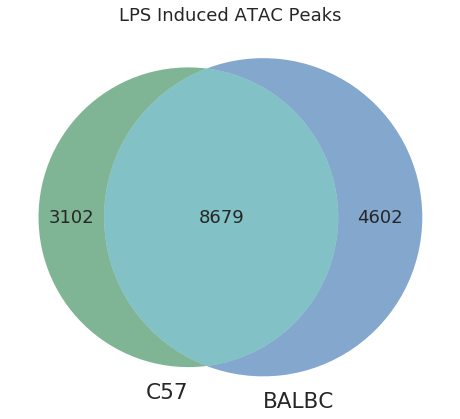

In [180]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['c57bl6j'][0]),
               set(peak_dict['balbcj'][0])],
     ax=ax,
     set_colors=('#006d2c', '#08519c'),
     set_labels=('C57', 'BALBC'),
     alpha=0.5)
ax.set_title('LPS Induced ATAC Peaks');

plt.savefig('./figures/venn2a_activated_peaks.png', bbox_inches='tight')

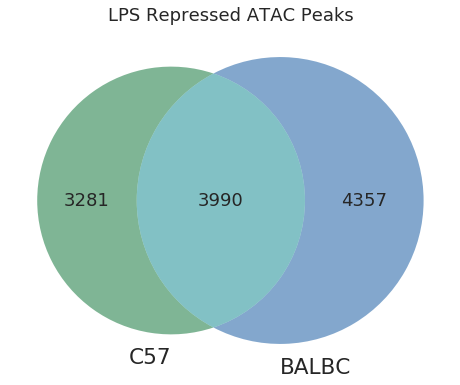

In [181]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['c57bl6j'][1]),
               set(peak_dict['balbcj'][1])],
     ax=ax,
     set_colors=('#006d2c', '#08519c'),
     set_labels=('C57', 'BALBC'),
     alpha=0.5)
ax.set_title('LPS Repressed ATAC Peaks');

plt.savefig('./figures/venn2_repressed_peaks.png', bbox_inches='tight')

# Compare Strain Specific Genes across treatments

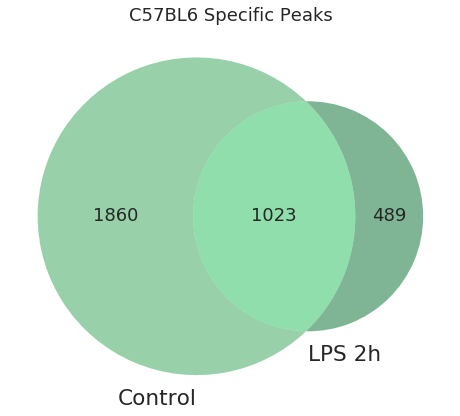

In [182]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['control'][0]),
               set(peak_dict['lps2h'][0])],
     ax=ax,
     set_colors=('#31a354', '#006d2c'),
     set_labels=('Control', 'LPS 2h'),
     alpha=0.5)
ax.set_title('C57BL6 Specific Peaks');

plt.savefig('./figures/venn2_c57bl6j_activated_peaks.png', bbox_inches='tight')

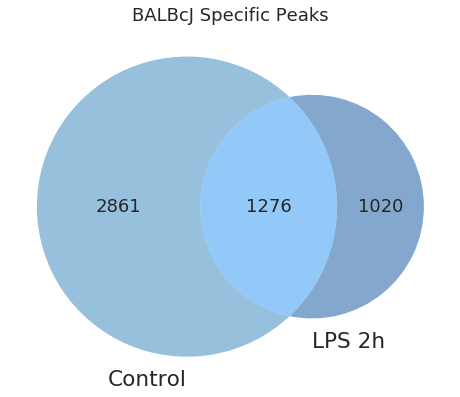

In [183]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['control'][1]),
               set(peak_dict['lps2h'][1])],
     ax=ax,
     set_colors=('#3182bd', '#08519c'),
     set_labels=('Control', 'LPS 2h'),
     alpha=0.5)
ax.set_title('BALBcJ Specific Peaks');

plt.savefig('./figures/venn2_balbcj_activated_peaks.png', bbox_inches='tight')

# Create bed files for visualization in browser

label all peaks post-hoc

In [26]:
%%bash

echo 'track name="kupffer_control_young_atac_merged" description="Kupffer Young Control ATAC All Strains"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check differential peak quality in browser

In [63]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [66]:
diff_peak.columns

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331C_TDT_s20210331_TCCTGAGC_CCTAGAGT.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331D_TDT_s20210331_GGACTCCT_GCGTAAGA.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407E_TDT_s20210407_GCTCATGA_CTCTCTAT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam',
       '/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407F_TDT_s20210407_ATCTCAGG_TATCCTCT.c57bl6j.bowtie2_shifted_from_

In [ ]:
diff_peak

In [68]:
diff_peak.sort_values('00_c57_lps2h vs. 01_balbcj_lps2h adj. p-value', ascending=True).head(10)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Gene Description,Gene Type,/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331C_TDT_s20210331_TCCTGAGC_CCTAGAGT.balbcj.bowtie2_shifted_from_BALBCJ.sam,/home/h1bennet/strains/data/ATAC/LPS_2hours/balbcj_Male_Kupffer_ATAC_LPS2hrFasted_20210331D_TDT_s20210331_GGACTCCT_GCGTAAGA.balbcj.bowtie2_shifted_from_BALBCJ.sam,/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407E_TDT_s20210407_GCTCATGA_CTCTCTAT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam,/home/h1bennet/strains/data/ATAC/LPS_2hours/c57bl6j_Male_Kupffer_ATAC_LPS2hrFasted_20210407F_TDT_s20210407_ATCTCAGG_TATCCTCT.c57bl6j.bowtie2_shifted_from_C57BL6J.sam,00_c57_lps2h vs. 01_balbcj_lps2h Log2 Fold Change,00_c57_lps2h vs. 01_balbcj_lps2h p-value,00_c57_lps2h vs. 01_balbcj_lps2h adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr1-24613094-2,chr1,24612971,24613171,+,964.299988,./atac_peak_files/balbc_kupffer_control_atac.i...,Intergenic,Intergenic,-25634.0,NM_007733,...,"collagen, type XIX, alpha 1",protein-coding,13.237855,12.687753,9.941526,9.940203,-12.478508,1.309232e-65,1.130194e-60,chr1:24612971-24613171
Merged-chr8-127441351-4,chr8,127441245,127441445,+,998.500000,./atac_peak_files/balbc_kupffer_control_atac.i...,"intron (NM_033620, intron 20 of 24)","intron (NM_033620, intron 20 of 24)",141693.0,NM_001013580,...,par-3 family cell polarity regulator,protein-coding,6.176114,6.039054,8.651348,8.614621,3.206928,2.541185e-48,1.096839e-43,chr8:127441245-127441445
Merged-chr1-24612753-3,chr1,24612652,24612852,+,821.333313,./atac_peak_files/balbc_kupffer_control_atac.i...,Intergenic,Intergenic,-25315.0,NM_007733,...,"collagen, type XIX, alpha 1",protein-coding,11.659668,10.872409,5.517765,5.457609,-8.008226,4.236458e-48,1.219041e-43,chr1:24612652-24612852
Merged-chr8-71603163-2,chr8,71603062,71603262,+,1000.000000,./atac_peak_files/c57_kupffer_control_atac.idr...,"intron (NM_001166213, intron 8 of 14)","intron (NM_001166213, intron 8 of 14)",5516.0,NM_001166213,...,"family with sequence similarity 129, member C",protein-coding,4.916754,4.898611,7.905949,7.983865,4.918001,3.906350e-39,8.430393e-35,chr8:71603062-71603262
Merged-chr1-173961686-3,chr1,173961598,173961798,+,983.055542,./atac_peak_files/balbc_kupffer_control_atac.i...,TTS (NM_011940),TTS (NM_011940),-19026.0,NM_001302650,...,interferon activated gene 203,protein-coding,7.749662,7.770713,4.585333,4.841071,-5.240792,4.191895e-35,6.031089e-31,chr1:173961598-173961798
Merged-chr16-45644656-2,chr16,45644550,45644750,+,1000.000000,./atac_peak_files/c57_kupffer_control_atac.idr...,"intron (NM_145389, intron 2 of 5)","intron (NM_145389, intron 2 of 5)",9468.0,NM_145389,...,"cDNA sequence, BC016579",protein-coding,4.742971,4.511518,7.889069,8.034778,6.034884,3.029540e-33,3.736072e-29,chr16:45644550-45644750
Merged-chr14-48422198-2,chr14,48422100,48422300,+,1000.000000,./atac_peak_files/c57_kupffer_control_atac.idr...,Intergenic,Intergenic,-23923.0,NM_001310584,...,transmembrane protein 260,protein-coding,5.379718,5.052185,7.692288,7.529361,3.722399,9.053412e-29,9.769197e-25,chr14:48422100-48422300
Merged-chr4-6222224-3,chr4,6222134,6222334,+,967.166687,./atac_peak_files/balbc_kupffer_control_atac.i...,Intergenic,Intergenic,31129.0,NM_026534,...,UBX domain protein 2B,protein-coding,5.068901,5.204354,7.325500,7.507632,3.712220,1.476933e-26,1.416625e-22,chr4:6222134-6222334
Merged-chr14-76755710-3,chr14,76755586,76755786,+,853.333313,./atac_peak_files/balbc_kupffer_lps_2hours_ata...,Intergenic,Intergenic,-4445.0,NR_153763,...,RIKEN cDNA 4930431P22 gene,ncRNA,5.195960,5.575892,7.580254,7.602403,3.337111,6.443352e-26,5.562224e-22,chr14:76755586-76755786
